In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

# Load the FITS file
filename = "./ecam-0046-r.fits"
hdul = fits.open(filename)
data = hdul[0].data
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  
DATE-OBS= '2023-05-20T09:32:28.224'                                             
EXP_TIME=                250.0 / Exposure Time (Seconds)                        
EXP_TYPE= 'Single  '           / Exposure Type (Single, Real Time, or Series)   
IMG_TYPE= 'Object  '           / Image Type (Bias, Flat, Dark, or Object)       
FILTER  = 'r       '           / Filter (Ha, B, V, g, r)                        
TEMP    = '-81.19  '           / CCD Temperature during Exposure                
COMMENT The big one. (g)    

In [16]:
# Calculate background statistics
mean, median, std = sigma_clipped_stats(data)
signal = data - median

# Define the star finder parameters
threshold = 1  # Adjust the threshold as needed
fwhm = 5  # Adjust the FWHM as needed
brightest_stars = 10  # Number of stars to find
daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold, brightest=brightest_stars, sky=mean, exclude_border=True)

# Find stars in the data
sources = daofind(signal)

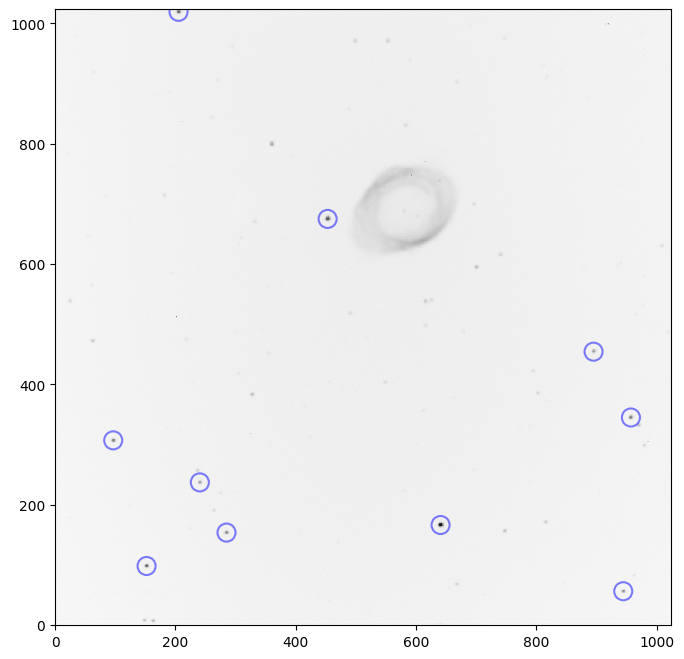

In [17]:
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=15.0)
norm = ImageNormalize(stretch=AsinhStretch())
fig = plt.figure(figsize=(10, 8))  # Adjust the width (10) and height (8) as desired
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5);

In [18]:
mask = apertures.to_mask(method='center')

In [19]:
mask[0]
roi_data = mask[0].cutout(data-median)

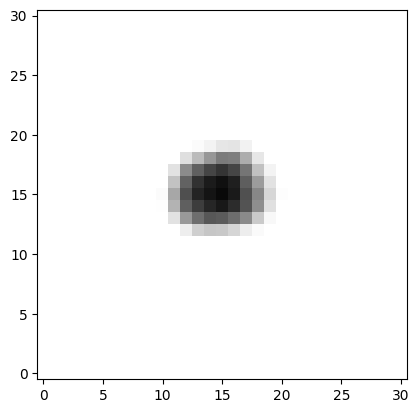

In [20]:
roi_data.shape
plt.imshow(roi_data, cmap='Greys', origin='lower', norm=norm,)

In [21]:
roi_data.sum()

782983.0

In [22]:
median

2766.0

In [23]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
aperture_photometry(data-median, apertures[0])['aperture_sum'][0]


774876.5024088306

In [24]:
# def calc_hfd(data, bg, aperture):
#     total_flux = aperture_photometry(data-bg, aperture)['aperture_sum'][0]

#     mask = aperture.to_mask(method='center')
#     roi_data = mask.cutout(data-bg)
#     dist_weighted_flux = 0
#     for (y,x), pix in np.ndenumerate(roi_data):
#         dist = np.sqrt(y*y+x*x)
#         if  dist < aperture_r:
#             dist_weighted_flux += pix * dist
#     return dist_weighted_flux / total_flux * 2
APERTURE_R = 10

def calc_hfd(signal, aperture):
    mask = aperture.to_mask(method='center')
    roi_data = mask.cutout(signal)
    dist_weighted_flux = 0
    for (y, x), pix in np.ndenumerate(roi_data):
        dist = np.sqrt(y*y+x*x)
        if dist < APERTURE_R:
            dist_weighted_flux += pix * dist

    # total_flux = aperture_photometry(signal, aperture)['aperture_sum'][0]
    total_flux = np.sum(roi_data)
    return dist_weighted_flux / total_flux * 2

In [25]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

# Extract the x and y coordinates of the detected stars
x_coords = sources['xcentroid']
y_coords = sources['ycentroid']

# Calculate the FWHM for each detected star
fwhm_values = []
hfd_values = []

for x, y in zip(x_coords, y_coords):
    xycen = centroid_quadratic(data, xpeak=x, ypeak=y)
    print(data[int(x), int(y)])  # need to check if the star is not saturated
    edge_radii = np.arange(25)
    rp = RadialProfile(signal, xycen, edge_radii, mask=None)
    fwhm_value = rp.gaussian_fwhm
    fwhm_values.append(fwhm_value)
    
    # HFD
    aperture = CircularAperture((x, y), r=APERTURE_R)
    hfd = calc_hfd(data, aperture)
    hfd_values.append(hfd)

2755
2862
2486
2891
2553
2747
2604
2669
2924
3061


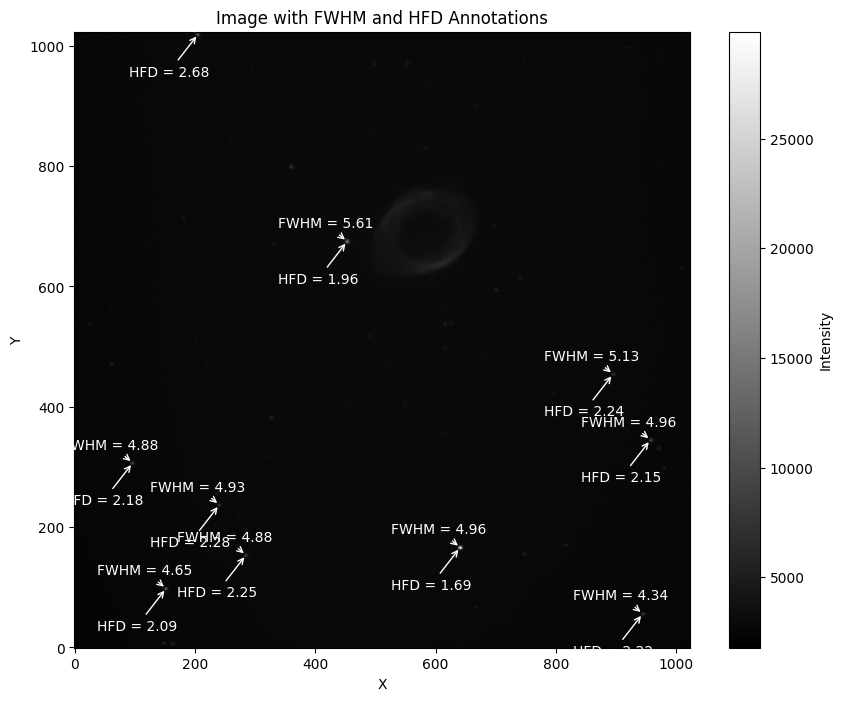

In [26]:
# Plot the image and FWHM annotations
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='gray', origin='lower')

# Add FWHM annotations
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    fwhm_value = fwhm_values[i]
    plt.annotate(f"FWHM = {fwhm_value:.2f}",
                 xy=(x, y), xycoords='data',
                 xytext=(-50, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", color='white'),
                 color='white')

# Add HFD annotations
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    hfd_value = hfd_values[i]
    plt.annotate(f"HFD = {hfd_value:.2f}",
                 xy=(x, y), xycoords='data',
                 xytext=(-50, -30), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", color='white'),
                 color='white')


plt.colorbar(label='Intensity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Image with FWHM and HFD Annotations')
plt.show()

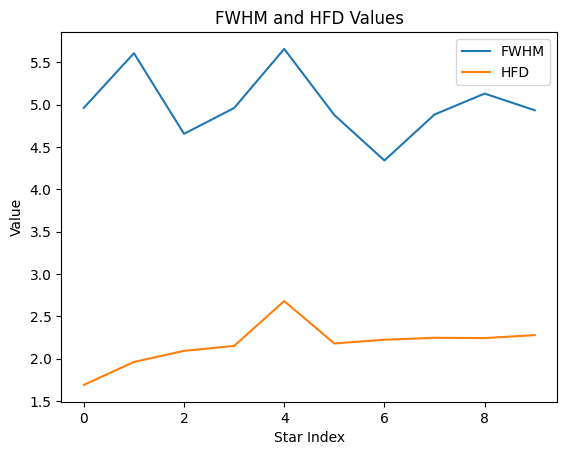

In [27]:
plt.plot(fwhm_values, label='FWHM')
plt.plot(hfd_values, label='HFD')
plt.legend()
plt.xlabel('Star Index')
plt.ylabel('Value')
plt.title('FWHM and HFD Values')
plt.show()
